In [1]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.7 MB/s 
     |████████████████████████████████| 636 kB 68.5 MB/s 
     |████████████████████████████████| 3.3 MB 65.5 MB/s 
     |████████████████████████████████| 895 kB 47.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd

# 1. Get Data

In [3]:
# read from csv file 
greek_ids = pd.read_csv('greek_ids.csv')

In [4]:
# Drop columns with no information
greek_ids = greek_ids.drop(['Unnamed: 0', 'Ύψος'], axis=1)

In [5]:
# convert it dictionary for easier 
dictQA= greek_ids.to_dict(orient = 'records')
# Check records
# dictQA[0]

# 2. Format Data 

In [10]:
# Proper Format of Data for Q.A. task
# load all dataset to list object 
data = []

for index in dictQA:
    for k, v in index.items():
      line = ' '.join(index.values()) + ", "+ k+  ": "+ v+ "<|endoftext|>"
      data.append(line)
    

In [11]:
# How the formated data looks
data[:15]

['K8529482 05/04/2010 Ιωάννα Ioanna Καράμπη Karampe Αριστόβουλος Ιππολύτη Τουρνά 14/02/2000 Δράμα Άρτα Κέρκυρα 45465/7 Υ.Α. Άρτα Δράμα, Αριθμός Ταυτότητας: K8529482<|endoftext|>',
 'K8529482 05/04/2010 Ιωάννα Ioanna Καράμπη Karampe Αριστόβουλος Ιππολύτη Τουρνά 14/02/2000 Δράμα Άρτα Κέρκυρα 45465/7 Υ.Α. Άρτα Δράμα, Ημερομηνία Έκδοσης: 05/04/2010<|endoftext|>',
 'K8529482 05/04/2010 Ιωάννα Ioanna Καράμπη Karampe Αριστόβουλος Ιππολύτη Τουρνά 14/02/2000 Δράμα Άρτα Κέρκυρα 45465/7 Υ.Α. Άρτα Δράμα, Όνομα: Ιωάννα<|endoftext|>',
 'K8529482 05/04/2010 Ιωάννα Ioanna Καράμπη Karampe Αριστόβουλος Ιππολύτη Τουρνά 14/02/2000 Δράμα Άρτα Κέρκυρα 45465/7 Υ.Α. Άρτα Δράμα, Given Name: Ioanna<|endoftext|>',
 'K8529482 05/04/2010 Ιωάννα Ioanna Καράμπη Karampe Αριστόβουλος Ιππολύτη Τουρνά 14/02/2000 Δράμα Άρτα Κέρκυρα 45465/7 Υ.Α. Άρτα Δράμα, Επώνυμο: Καράμπη<|endoftext|>',
 'K8529482 05/04/2010 Ιωάννα Ioanna Καράμπη Karampe Αριστόβουλος Ιππολύτη Τουρνά 14/02/2000 Δράμα Άρτα Κέρκυρα 45465/7 Υ.Α. Άρτα Δράμα,

# 3. Split my Data into train and validatons and test


In [12]:
len(data)

13000

#4. Tokenization

In [13]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config

In [14]:
# set model name 
model_name = 'gpt2'

In [15]:
# add extra special tokens
tokenizer = GPT2Tokenizer.from_pretrained(model_name,
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>' )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Check the tokenizer parameters

In [16]:
tokenizer.special_tokens_map 

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'pad_token': '<|pad|>',
 'unk_token': '<|endoftext|>'}

In [17]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|endoftext|> token has the id 50256
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50257


In [19]:
# +1 for any case 
max_length = max([len(tokenizer.encode(row)) for row in data])
max_length = max_length +1
print(f'The longest text is {max_length} tokens long.')

The longest text is 242 tokens long.


# 5. PyTorch Datasets & Dataloaders

The batch size will affect the training time so it is always a good idea to set the batch to the highest number you can fit in the memory of the GPU you are using for training, however this hyper parameter should only affect training time but not model performance. A batch size too large won't fit in memory for some GPUS so you will have to adjust this parameter if you aren't allocated a T4 or K80.

In [20]:
# Set batch size
batch_size = 4

In [21]:
!nvidia-smi

Tue Jul 27 09:25:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
# Libs
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

In [23]:
class IDDataset(Dataset):

  def __init__(self, df, tokenizer, gpt2_type="gpt2", max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for line in df:
      encodings_dict = tokenizer(line, truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

## Create Dataset 

In [24]:
from torch.utils.data import random_split

In [25]:
dataset = IDDataset(data, tokenizer, max_length=max_length)

In [26]:
dataset[10]

(tensor([   42,  5332,  1959, 40149,  8870,    14,  3023,    14, 10333,  7377,
           247, 49535,   138,   105, 26180, 26180, 17394, 27853,  7697,  7377,
           248, 17394, 33643,   138,   105, 34703, 46582,   138,   115,  9375,
           321,   431,  7377,   239, 33643, 29945, 38392, 32830,   139,   234,
         26638, 26517,   139,   227, 39377, 26517, 35558,  7377,   247, 46582,
         46582, 26517, 39377,   139,   235, 32830,   138,   115,  7377,    97,
         26517,   139,   227, 33643, 26180,   138,   105,  1478,    14,  2999,
            14, 11024, 37455, 33643,   138,   105, 34703, 17394,  7377,   228,
         33643, 32830, 17394,  7377,   248,   138,   255, 33643, 43000,   139,
           227, 33643, 17394,   604,  4051,  2996,    14,    22,  7377,    98,
            13,   138,   239,    13,  7377,   228, 33643, 32830, 17394, 37455,
         33643,   138,   105, 34703, 17394,    11,  7377,   248, 17394, 32830,
         17394, 42063, 49535, 42063,   138,   106,  

In [27]:
train_size = int(0.85 * len(dataset))
val_size = len(dataset)-train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#f'There are {train_size} samples for training, and {val_size} samples for validation testing'
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

11,050 training samples
1,950 validation samples


## Create Dataloader

Next we will create the dataloader object which will feed the neural network, this combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

In [28]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [29]:
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset), # Sampling for training is Random
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

# Finetune GPT2 Language Model

In [30]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

## Set GPU

[GPU or CPU](https://stackoverflow.com/questions/63302534/how-to-write-torch-devicecuda-if-torch-cuda-is-available-else-cpu-as-a-f)

In [31]:
# cleaning the occupied cuda memory
torch.cuda.empty_cache()

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained(model_name, output_hiden_states=False)

# Create the instance of the model 
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)
# set the token size embedding length
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU 
# if not available then run on cpu 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.cuda()

#  This step is optional but it wiil enable reproducible runs
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
#configuration

## Training parameters

In [32]:
# We wil create a few variables to define the training parameters of the model
# epochs are the  {training rounds}
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 4
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

AdamW is the optimizer of choice for training many models, we will be using Hugging Face's implementation and all of it's defaults, we will also set the number of epochs here, again as we are fine tuning, not retraining, we don't need to run very long models.

In [33]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [34]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [35]:
import random
import time
import datetime

In [36]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

## model train

In [37]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,763. Loss: 1.5222768783569336.   Elapsed: 0:00:29.
0:  bipartisan5 274040 19/09/2018 Κόραυτας Khakulkarokakhou Θαλλχή Karakoulou Χερένα Ρερχεινη Kontakou Ειάκδήρη Κολάκη Νικθνα Kontakou Μακηλκη Κεραχεινη Υ.Α. Α. Ηιρθνα: Θερυσσσκη, Τάκτετείς Υ.Α. Θερουσσκη: Χασστα: Υ.Α. Περ


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,763. Loss: 1.2592811584472656.   Elapsed: 0:01:00.
0:  increasing7694936 01/01/2019 Παυμανή Katsios Ξανερβίνωης Kuroukas Ιωφμήνάνη Ενίδα Άδοκης Δέττσαλία 11/06/1981 Κατερος Αίνουμα 29227/9 Υ.Α. Κατερος Επίδα Άδοκης, Δέτσαλία 11/06/1981


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,763. Loss: 0.9486419558525085.   Elapsed: 0:01:32.
0: day551730 29/02/2008 Λαστεμίδρου Agathe Θεσενώη Αξιλτίουνουλη Πανούκρη Άρυτρίδα Σπώρου 25/08/1943 Ηθειά Λιβασιά Καβάλα 62292/6 Υ.Α. Καβάλα 62292/6 Ηθειά, Ημερομηνία Έκδοσης: 25/08/1943


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,763. Loss: 0.8226566314697266.   Elapsed: 0:02:04.
0:  Hang254067 29/08/2011 Ανφούλας Klebkias Στώνας Πανηκαρος Μενώ Χαρκανά Μαυλή 25/03/1950 Χανικίδα Αχαΐα Πύργος 67013/3 Υ.Α. Αχαΐα Χανικίδα, Επώνυμο: Χανικίδα Αχαΐα


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,763. Loss: 0.8454007506370544.   Elapsed: 0:02:37.
0:  foods93384382 20/10/2009 Δοδαμηνα Aedona Κουλάγγκη Karampe Θεοφώτη Μαγνανά 29/10/1926 Φωκίδα Τρίπολη Πύργος 13497/9 Υ.Α. Τρίπολη Φωκίδα, Ημερομηνία Γέννησης: 13497/9


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,763. Loss: 0.7821696400642395.   Elapsed: 0:03:09.
0:  trail3394751 20/03/2008 Δούλιος Kleanthes Ραύγας Eusepoulos Μιρός Καρηώ Μαράφιος Τιαλία Ακαρχούδου 19/07/1918 Ζάκυνθος Άρτα Κατερίνη 58693/3 Υ.Α. Άρτα Ζάκυνθος Άρτα, Πατρώνυμο: Μιρός


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,763. Loss: 0.7377480268478394.   Elapsed: 0:03:43.
0: intend5979630 08/05/2017 Ηλιανίκος Marikaelos Μπασίτιος Tsiplas Γεωρισάς Χρισσαυτσίου 06/07/2001 Άρτα Κέρκυρα Χαλκίδα Αργοστόλι 57136/5 Υ.Α. Κέρκυρα Άρτα, Όνομα: Ηλιανίκος


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,763. Loss: 0.6886084079742432.   Elapsed: 0:04:16.
0:  surround7662587 06/01/2012 Ανάμοτης Theodoulos Φατερίππας Makarios Κλυζάτιος Φουλείδη Τσιάδα 23/06/1963 Ιωάννινα Χανιά Πύργος 76578/9 Υ.Α. Χανιά Ιωάννινα, Given Name: Theodoulos


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,763. Loss: 0.6500794291496277.   Elapsed: 0:04:49.
0:  reflex5520596 17/07/2015 Ασταλήνη Iasonas Γεοκλίδης Lemones Αγυρής Πηγαυρία Τζανταρίου 06/05/1954 Ηλεία Χανιά Έδεσσα 62085/9 Υ.Α. Χανιά Ηλεία, Όνομα: Αγυρής


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,763. Loss: 0.624940037727356.   Elapsed: 0:05:22.
0:  display8307247 24/02/2020 Ισούσης Ioannes Κοντέλης Koutsares Βλέμαριος Σιλιόμπη Τσιραρή 14/08/1968 Άρτα Ηγουμενίτσα Τρίπολη 65012/5 Υ.Α. Ηγουμενίτσα Άρτα, Surname: Koutsares


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,763. Loss: 0.5929815769195557.   Elapsed: 0:05:55.
0:  pastor8098510 10/07/2015 Ντότσιος Ntotse Μαρόπουλος Karopoulos Αντάνης Ζυβέντα Χαρυά Βησερίου 01/10/1930 Φωκίδα Κατερίνη Λιβαδιά 82330/2 Υ.Α. Κατερίνη Φωκίδα, Given Name: Ntotse


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,763. Loss: 0.5756650567054749.   Elapsed: 0:06:28.
0:  illicit1933152 16/08/2012 Φοίβος Phoibeos Χαλκιόπης Khasape Ρεβέκος Πύρος Ζαβιανουλέα Μαραγυρου 26/01/1917 Καρδίτσα Χαλκίδα Αγ. Νικόλαος 99355/8 Υ.Α. Χαλκίδα Καρδίτσα, Ημερομηνία Έκδοσης: 16/08/2012


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,763. Loss: 0.5171040892601013.   Elapsed: 0:07:01.
0:  Liberation8982785 24/01/2019 Σάρρος Sarros Κουτσούρης Koures Αυγόριστος Λαουκία Κυκουθάδη 27/03/1916 Πρέβεζα Κοζάνη Μεσολόγγι 55266/6 Υ.Α. Κοζάνη Πρέβεζα, Επίθετο Μητέρας: Κυκουθάδη


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,763. Loss: 0.5046306848526001.   Elapsed: 0:07:35.
0:  Nam2787446 08/08/2014 Φρύντιος Phruneinos Πολυξένης Poulias Διονυσής Μανδρίκα Σπυρζέα 27/12/1973 Άρτα Κατερίνη Λιβαδιά 51676/9 Υ.Α. Κατερίνη Άρτα, Ημερομηνία Έκδοσης: 08/08/2014


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,763. Loss: 0.48268166184425354.   Elapsed: 0:08:08.
0: ION8192097 22/12/2018 Διαλεκτή Dialekte Κοτσιούδη Kuritsaou Χαρίτου Khoroze Θησεύς Χριστιανοπούλου 22/12/1959 Ηράκλειο Άρτα Ιωάννινα 19587/4 Υ.Α. Άρτα Ηράκλειο, Ημερομηνία Έκδοσης: 22/12/2018


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,763. Loss: 0.48589998483657837.   Elapsed: 0:08:42.
0:  glimpse0762794 27/10/2012 Πίνδαρος Pindaros Κασκαριχάς Katarakhias Γκιλίας Φρανή Καρουγιάννη 11/11/1948 Λακωνία Καλαμάτα Λάρισα 75359/2 Υ.Α. Καλαμάτα Λακωνία, Όνομα: Πίνδαρος


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,763. Loss: 0.45791324973106384.   Elapsed: 0:09:15.
0:  Laure9456827 13/07/2009 Γκιρινός Gkribos Σπαπθάρη Spapatos Βάιος Νεοκλή Ναυσοπούλου 05/02/1989 Άρτα Χανιά Πύργος 75359/7 Υ.Α. Χανιά Άρτα, Καταγωγή: Άρτα Χανιά


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,763. Loss: 0.46337035298347473.   Elapsed: 0:09:48.
0: ism0042991 18/03/2007 Σπυριδάκη Spuridon Ασαργιώτης Asarides Ακριβός Γεράσιμος Ζουκίμη 29/06/1963 Έβρος Δράμα Καρπενήσι 07320/4 Υ.Α. Δράμα Έβρος, Πατρώνυμο: Ακριβός


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,763. Loss: 0.40014728903770447.   Elapsed: 0:10:21.
0: oun3868798 03/02/2019 Μυρσίνη Mursine Σπασώτη Spasegkou Σωκράτης Αυγή Χρυσαυγιάννη 21/11/1936 Θεσσαλονίκη Καρπενήσι Μεσολόγγι 04971/1 Υ.Α. Καρπενήσι Θεσσαλονίκη, Πατρώνυμο: Σωκράτης


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,763. Loss: 0.45142030715942383.   Elapsed: 0:10:55.
0:  election2799441 13/04/2014 Ισμήνη Ismene Λαέρπη Lebente Γεωργή George Κομνηνός Γιαννά Παπανδρέου 15/08/1989 Χίος Καστοριά Καλαμάτα 68876/8 Υ.Α. Καστοριά Χίος, Όνομα: Ισμήνη


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,763. Loss: 0.37821775674819946.   Elapsed: 0:11:28.
0:  crazy6758295 03/12/2018 Κάρολος Karolos Γαλάντζος Alexandros Μαύρος Μαρεντζή Μπονέλη 09/04/1946 Ξάνθη Κομοτηνή Ηγουμενίτσα 04219/2 Υ.Α. Κομοτηνή Ξάνθη, Πατρώνυμο: Μαύρος


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,763. Loss: 0.46229031682014465.   Elapsed: 0:12:01.
0:  bench9128884 06/08/2013 Φρεννίκη Pherenike Ευτμανούλου Georgoula Ασποστολία Γκόβα 09/02/1953 Κοζάνη Πολύγυρος Βέροια 57973/8 Υ.Α. Πολύγυρος Κοζάνη, Ημερομηνία Έκδοσης: 06/08/2013


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  2,763. Loss: 0.3926316201686859.   Elapsed: 0:12:35.
0:  incorporated3553304 29/10/2012 Τσαμπίκος Tsampikos Κοντογιάννης Konstantogiannes Λάμπρος Παναγιώτα Χρυσή 19/12/1948 Φθιώτιδα Δράμα Καβάλα 16609/3 Υ.Α. Δράμα Φθιώτιδα, Όνομα: Τσαμπίκος


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  2,763. Loss: 0.3890782594680786.   Elapsed: 0:13:08.
0: Peter9452342 07/01/2016 Κλαίρη Klaire Τσικρετάκη Tsikrika Δαμιανός Γαλαντατάνη Κουτσούμπεη 24/07/1978 Ηλεία Πύργος Κομοτηνή 58085/4 Υ.Α. Πύργος Ηλεία, Given Name: Klaire


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  2,763. Loss: 0.4084727466106415.   Elapsed: 0:13:41.
0: uring5825465 06/04/2013 Κυπαρισσία Kuparissia Μπουτζούρη Mpournournodoroze Ιάκωβος Θεοδοσία Φιλαρέτου 19/06/1945 Χίος Αργοστόλι Καρδίτσα 0989874/9 Υ.Α. Αργοστόλι Χίος, Αριθμός Ταυτότητας: Mpournodoroze


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  2,763. Loss: 0.4253086745738983.   Elapsed: 0:14:14.
0:  reproductive9811180 17/06/2019 Ξανθή Ksanthe Λουδένη Lekhronia Βουλγερίας Μινέρβα Βαρβάνου 09/06/1959 Άρτα Άρτα Χανιά 98034/3 Υ.Α. Άρτα Άρτα, Επώνυμο: Λουδένη


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  2,763. Loss: 0.3908545672893524.   Elapsed: 0:14:47.
0:  zone7449166 10/05/2013 Καλομοίρη Kalomoira Χοντζή Khontzia Αρτέμιος Ιουλιανή Φωτακοπούλου 16/08/1917 Φθιώτιδα Καβάλα Χίος 18260/3 Υ.Α. Καβάλα Φθιώτιδα, Ημερομηνία Γέννησης: 16/08/1917

  Average training loss: 0.73
  Training epoch took: 0:15:09

Running Validation...
  Validation Loss: 0.32
  Validation took: 0:00:48

======== Epoch 2 / 4 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,763. Loss: 0.34437182545661926.   Elapsed: 0:00:32.
0:  commits0559201 07/08/2018 Χαραλαμπία Kharalampia Τσαλτσούρου Tsantou Αθηνάδωρος Αρετή Μποσάκη 21/04/1956 Φλώρινα Τρίκαλα Έδεσσα 18959/8 Υ.Α. Τρίκαλα Φλώρινα, Mητέρας Όνομα: Αρετή


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,763. Loss: 0.3869008421897888.   Elapsed: 0:01:05.
0:  irony7027296 06/08/2015 Τρισεύγενη Triseugene Κατσαχάκη Katsakhake Ζαφείρης Τριαντάφυλλη Σφακιανίδου 14/08/1945 Άρτα Χανιά Άρτα 78479/7 Υ.Α. Χανιά Άρτα 78479/7, Ημερομηνία Έκδοσης: 06/08/2015


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,763. Loss: 0.33395713567733765.   Elapsed: 0:01:38.
0:  Sah0862711 18/12/2008 Φωκίων Phokion Αγγελής Aggeles Δωρόθεος Πανδώρα Μητσοπούλου 06/02/1977 Σέρρες Σάμος Χαλκίδα 11695/6 Υ.Α. Σάμος Σέρρες, Αρχή Έκδοσης Δελτίου: Υ.Α. Σάμος Σέρρες


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,763. Loss: 0.3239092230796814.   Elapsed: 0:02:12.
0:  Bryan8198899 29/08/2010 Βαρθολομαίος Bartholomaios Καραμμάνης Karamanes Ρίζος Καλλιόπη Βουλτσινή 16/08/1970 Χαλκιδική Ιωάννινα Σπάρτη 79412/6 Υ.Α. Ιωάννινα Χαλκιδική, Surname: Karamanes


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,763. Loss: 0.33131691813468933.   Elapsed: 0:02:45.
0:  spirits6271171 12/11/2011 Ευθυμία Euthumia Ταυλαρίδου Taularidou Πανορμίτης Ανδρομέδα Σπηλιάδου 23/05/1978 Καστοριά Λαμία Σέρρες 18958/6 Υ.Α. Λαμία Καστοριά, Όνομα: Ευθυμία


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,763. Loss: 0.32248640060424805.   Elapsed: 0:03:18.
0:  sees2582558 07/11/2019 Σελήνη Selene Κουμάρα Koumara Άριστος Αποστολία Σκατίλα 05/01/1960 Ζάκυνθος Πολύγυρος Κοζάνη 51666/3 Υ.Α. Πολύγυρος Ζάκυνθος, Ημερομηνία Έκδοσης: 07/11/2019


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,763. Loss: 0.3218693733215332.   Elapsed: 0:03:51.
0:  hungry6524716 20/08/2018 Εύκλεια Eukleia Σουλτσινάκη Paulitianake Ευδόξιος Πολυξένη Πετσιά 02/04/1960 Κεφαλληνία Λιβαδιά Άρτα 43309/3 Υ.Α. Λιβαδιά Κεφαλληνία, Επώνυμο: Σουλτσινάκη


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,763. Loss: 0.268251895904541.   Elapsed: 0:04:25.
0:  PT7246423 30/11/2013 Αστέρω Astero Δημούλα Demoula Μενέλαος Μαράντα Ξυγκάκου 06/03/1924 Βοιωτία Πύργος Καρδίτσα 89560/3 Υ.Α. Πύργος Βοιωτία, Αριθμός Ταυτότητας: PYM83960/3


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,763. Loss: 0.2722136378288269.   Elapsed: 0:04:58.
0: ü5947268 09/08/2014 Φίλιππος Philippos Θωμόπουλος Thomopoulos Ευμένιος Ιούλια Αποστολίδου 22/12/1974 Ρέθυμνο Ζάκυνθος Λευκάδα 09084/9 Υ.Α. Ζάκυνθος Ρέθυμνο, Given Name: Philippos


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,763. Loss: 0.23576125502586365.   Elapsed: 0:05:31.
0: ruce6530760 22/07/2018 Θωμαίς Thomais Σαμτανίδου Samtanidou Διαμανός Μικές Αρτεμισία 11/12/1991 Θεσσαλονίκη Βέροια Ερμούπολη 37541/6 Υ.Α. Βέροια Θεσσαλονίκη, Given Name: Thomais


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,763. Loss: 0.2700442969799042.   Elapsed: 0:06:04.
0:  derivatives9370042 27/04/2018 Ηρόδοτος Erodotos Σπάλας Spalas Τιμόθεος Αηδόνα Μπαλή 20/02/1916 Καστοριά Μυτιλήνη Καβάλα 01981/2 Υ.Α. Μυτιλήνη Καστοριά, Όνομα: Ηρόδοτος


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,763. Loss: 0.2416280210018158.   Elapsed: 0:06:37.
0: 4805998 01/03/2007 Αύγουστος Augoustos Βώσσος Bossos Αργύριος Νεκταρία Τσαμοπούλου 25/01/1925 Αργολίδα Καστοριά Ρέθυμνο 60641/5 Υ.Α. Καστοριά Αργολίδα, Αρχή Έκδοσης Δελτίου: Υ.Α. Καστοριά Αργολίδα


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,763. Loss: 0.26324114203453064.   Elapsed: 0:07:11.
0:  remembering879954401 30/11/2007 Χρυσόστομος Khrusostomos Κοραλίδης Kordatzes Ευσεβείας Καλλιρόη Λαμπρινή 15/12/1972 Ημαθία Καστοριά Καρπενήσι 08212/8 Υ.Α. Καστοριά Ημαθία, Given Name: Khrusostomos


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,763. Loss: 0.24331046640872955.   Elapsed: 0:07:44.
0:  Sources8005641 12/10/2015 Χαρδιώ Kharrenia Μαρτζούκου Martzoukou Λουκάς Ευρούκλεια Αργυράκη 31/01/1933 Λέσβος Κόρινθος Κοζάνη 46272/3 Υ.Α. Κόρινθος Λέσβος, Όνομα: Χαρδιώ


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,763. Loss: 0.23636506497859955.   Elapsed: 0:08:17.
0: ems8722596 04/03/2010 Ευστρατία Eustratia Σαρρή Sarre Αντώνιος Παντούλα Ζιάρα 04/03/1977 Αττική Κιλκίς Αγ. Νικόλαος 09333/7 Υ.Α. Κιλκίς Αττική, Όνομα: Ευστρατία


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,763. Loss: 0.15489305555820465.   Elapsed: 0:08:50.
0: tz0528331 18/02/2017 Συμεωνία Sumeonia Κατσαμιώτη Katsamiotake Αντύπας Ναυσικά Μπαλανίκα 24/07/1945 Αρκαδία Δράμα Καβάλα 30120/4 Υ.Α. Δράμα Αρκαδία, Mητέρας Όνομα: Ναυσικά


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,763. Loss: 0.19172868132591248.   Elapsed: 0:09:23.
0: matic2875986 12/05/2016 Ιάσονας Iasonas Κοττσίκας Kottikas Τίτος Ελέσσα Μπαλή 08/02/1956 Πέλλα Βέροια Βέροια 22965/7 Υ.Α. Βέροια Πέλλα, Given Name: Iasonas


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,763. Loss: 0.18910883367061615.   Elapsed: 0:09:56.
0:  synd2770396 24/01/2007 Ιορδανία Iordania Μπατσάκη Manta Ιορδάνης Αστέρω Asteroudake Αριστοφάνης Ιουλιανία 26/07/1941 Κέρκυρα Κατερίνη Λαμία 05973/7 Υ.Α. Κατερίνη Κέρκυρα, Επίθετο Μητέρας: Ιουλιανία


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,763. Loss: 0.20976851880550385.   Elapsed: 0:10:30.
0:  gam9369446 02/06/2013 Ευθύμιος Euthumios Τσότρας Tsotras Λουκιανός Ματθίλδη Κουζουλά 24/04/1927 Σέρρες Γρεβενά Έδεσσα 87714/3 Υ.Α. Γρεβενά Σέρρες, Πατρώνυμο: Λουκιανός


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,763. Loss: 0.21011796593666077.   Elapsed: 0:11:03.
0:  injury4803172 29/05/2019 Ξανθή Ksanthe Χρυσή Khrusou Λέων Σπυριδούλα Αγραφιώτη 15/03/1942 Χίος Κατερίνη Καστοριά 78206/7 Υ.Α. Κατερίνη Χίος, Δημότης: Καστοριά 78206/7


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,763. Loss: 0.17622841894626617.   Elapsed: 0:11:36.
0: aza2491163 09/01/2015 Ματθαίος Matthaios Σιρανούς Sarantes Ρίζος Γιαννούλα Ιωακείμ 18/02/2019 Αιτωλία & Ακαρνανία Καρπενήσι Καρπενήσι 85427/4 Υ.Α. Καρπενήσι Αιτωλία & Ακαρνανία, Επίθετο Μητέρας: Ιωακείμ


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,763. Loss: 0.15673981606960297.   Elapsed: 0:12:10.
0:  membrane6766605 10/04/2018 Ερμόλαος Ermolaos Τζιρατούκος Tsiaras Αθηνόδωρος Περσεφόνη Παπανδρέου 22/12/1924 Ηράκλειο Μεσολόγγι Καλαμάτα 62473/5 Υ.Α. Μεσολόγγι Ηράκλειο, Πατρώνυμο: Αθηνόδωρος


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  2,763. Loss: 0.19373327493667603.   Elapsed: 0:12:43.
0: ijing2614508 29/01/2012 Αδαμάντιος Adamantios Τζιγκούς Tzigkouas Αριστείδης Ελένη Καραγάκου 24/03/1937 Λευκάδα Ηράκλειο Ξάνθη 30773/1 Υ.Α. Ηράκλειο Λευκάδα, Ημερομηνία Έκδοσης: 29/01/2012


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  2,763. Loss: 0.17303915321826935.   Elapsed: 0:13:16.
0:  cast2574412 13/04/2018 Σάρα Sarra Πρέκα Preka Βαρσάμος Χρυσαφένια Σπανίδου 23/01/1917 Χανιά Βόλος Χαλκίδα 11082/9 Υ.Α. Βόλος Χανιά, Surname: Preka


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  2,763. Loss: 0.21112993359565735.   Elapsed: 0:13:49.
0:  purch6798228 27/06/2019 Ευσεβείδης Eustratios Τσιαντάς Tsiantas Λουδοβίκος Παναγιώτα Μαυραειδή 15/03/1969 Λασσίθι Κομοτηνή Λιβαδιά 48536/2 Υ.Α. Κομοτηνή Λασσίθι, Όνομα: Ευσεβείδης


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  2,763. Loss: 0.12411264330148697.   Elapsed: 0:14:23.
0:  shoulders0963845 07/11/2007 Ευσταθία Eustathia Καρατάσου Karatasou Ορέστης Θεοφανία Βραδή 26/01/1993 Αχαΐα Σπάρτη Καρπενήσι 18551/3 Υ.Α. Σπάρτη Αχαΐα, Ημερομηνία Έκδοσης: 07/11/2007


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  2,763. Loss: 0.16725952923297882.   Elapsed: 0:14:56.
0:  built0776611 13/06/2010 Απόστολος Apostolos Παπαχριστοδούλου Papakhrestomidou Ιωνάς Σωφρονία Καλογιαννάκη 07486/2 Υ.Α. Αία Λάρισα �486/2, Καταγωγή: Υ.Α. Αία Λάρισα �486/2

  Average training loss: 0.25
  Training epoch took: 0:15:17

Running Validation...
  Validation Loss: 0.08
  Validation took: 0:00:48

======== Epoch 3 / 4 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,763. Loss: 0.19440005719661713.   Elapsed: 0:00:32.
0:  openly8946188 02/03/2009 Ευκλείδης Eukleides Φανουδάκης Phaniakoudakes Ξανθός Λευκοθέα Καραντάνα 08/12/1961 Φθιώτιδα Ερμούπολη Τρίπολη 02744/2 Υ.Α. Ερμούπολη Φθιώτιδα, Mητέρας Όνομα: Λευκοθέα


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,763. Loss: 0.11784408986568451.   Elapsed: 0:01:05.
0:  halted3507853 22/10/2015 Θέμις Themis Χορτάτου Khortatou Μερκούριος Ξανθή Δημτσούδη 05/05/1960 Λάρισσα Κατερίνη Λάρισα 89239/5 Υ.Α. Κατερίνη Λάρισσα, Όνομα: Θέμις


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,763. Loss: 0.13274432718753815.   Elapsed: 0:01:38.
0:  Nik8300791 24/12/2015 Βλάσης Blases Ράλλης Ralles Δημοσθένης Δάφνη Καλογιάννη 06/02/2005 Ξάνθη Βόλος Χαλκίδα 11082/9 Υ.Α. Βόλος Ξάνθη, Δημότης: Χαλκίδα 11082/9


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,763. Loss: 0.07683625817298889.   Elapsed: 0:02:11.
0:  tin2138056 18/11/2014 Βαλάντης Balantes Σέργιος Ziogianos Φρειδερίκος Εριέτα Καπανταϊδάκη 07/02/1981 Χίος Καρπενήσι Θεσσαλονίκη 39851/3 Υ.Α. Καρπενήσι Χίος, Ημερομηνία Γέννησης: 07/02/1981


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,763. Loss: 0.07605663686990738.   Elapsed: 0:02:45.
0:  clinical2138056 18/11/2018 Ξανθός Ksanthos Ψάλτης Psaltes Αθηναγόρας Ήβη Σταματούκου 14/03/1979 Σέρρες Τρίκαλα Θεσσαλονίκη 11262/8 Υ.Α. Τρίκαλα Σέρρες, Given Name: Ksanthos


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,763. Loss: 0.07695193588733673.   Elapsed: 0:03:18.
0: lections1716001 08/09/2014 Πανταζής Pantazes Θεοδωρόπουλος Theodoropoulos Ζαφείρης Στεργιανή Μπαλανίκα 21/03/1920 Δράμα Πάτρα Μυτιλήνη 71266/3 Υ.Α. Πάτρα Δράμα, Αρχή Έκδοσης Δελτίου: Υ.Α. Πάτρα Δράμα


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,763. Loss: 0.10258395969867706.   Elapsed: 0:03:51.
0: els5709225 17/04/2019 Οδυσσεύς Odusseus Κεσαλίδης Kesalides Διαμαντής Κωνσταντίνα Καλδή 19/01/1966 Λασσίθι Φλώρινα Ερμούπολη 17336/9 Υ.Α. Φλώρινα Λασσίθι, Επώνυμο: Κεσαλίδης


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,763. Loss: 0.09262735396623611.   Elapsed: 0:04:24.
0: lab0176752 13/05/2019 Ίκαρος Ikaros Βώσσος Bossos Ανανιάδης Παρέσσα Παπαδήμα 07/03/1944 Έβρος Κόρινθος Πύργος 41145/3 Υ.Α. Κόρινθος Έβρος, Surname: Bossos


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,763. Loss: 0.0703602284193039.   Elapsed: 0:04:57.
0:  triple9572321 27/12/2017 Ματθαίλδη Matthilde Πhelle Αστέριος Μαργιέττα Σταματούκου 06/04/1963 Θεσσαλονίκη Θεσσαλονίκη Κιλκίς 88109/7 Υ.Α. Θεσσαλονίκη Θεσσαλονίκη, Επίθετο Μητέρας: Σταματούκου


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,763. Loss: 0.07237598299980164.   Elapsed: 0:05:31.
0: 2209369446 02/06/2013 Ευθύμιος Euthumios Τσιάρας Tsiaras Λουκιανός Σταματίνα Αγραφιώτη 31/10/1923 Κιλκίς Καρδίτσα Πύργος 88379/4 Υ.Α. Καρδίτσα Κιλκίς, Επώνυμο: Τσιάρας


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,763. Loss: 0.1037498265504837.   Elapsed: 0:06:04.
0:  See7113557 07/02/2019 Πέτρα Petra Βασιλάκη Basilake Βαρσάμος Λεωνιδιά Βαλκάνου 12/06/1954 Βοιωτία Καστοριά Ρόδος 46276/8 Υ.Α. Καστοριά Βοιωτία, Ημερομηνία Γέννησης: 12/06/1954


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,763. Loss: 0.07763001322746277.   Elapsed: 0:06:37.
0: @@2770396 24/03/2007 Ιορδανία Iordania Σπασέγκου Spasegkou Ηρόδοτος Παταπία Τσαντίδου 23/09/1973 Τρίκαλα Τρίπολη Γρεβενά 85519/7 Υ.Α. Τρίκαλα Τρίκαλα, Given Name: Iordania


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,763. Loss: 0.06631293892860413.   Elapsed: 0:07:10.
0:  host0070210 14/09/2012 Υπαπαντή Upapante Ζερβά Zerba Επαμεινώνδας Θεώνη Τριφτανίδου 30/01/1943 Λάρισσα Έδεσσα Ρόδος 50750/5 Υ.Α. Έδεσσα Λάρισσα, Αριθμός Ταυτότητας: OP0070210


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,763. Loss: 0.051130425184965134.   Elapsed: 0:07:44.
0: role6524716 20/02/2009 Σουλτάνα Soultana Τζιρατούδη Tziratoude Αλέξανδρος Περσεφόνη Μπατζάνη 08/02/1981 Κοζάνη Βέροια Ρόδος 04199/5 Υ.Α. Βέροια Κοζάνη, Αρχή Έκδοσης Δελτίου: Υ.Α. Βέροια Κοζάνη


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,763. Loss: 0.0519038587808609.   Elapsed: 0:08:17.
0: iac8536462 03/11/2008 Δανάη Danae Ζερβά 19/01/1958 Ευρυδίκη Eurudike Κεσίσης Λαμπρινή Βασιλείου 12/09/1972 Σάμος Καβάλα Σπάρτη 61055/4 Υ.Α. Καβάλα Σάμος, Ημερομηνία Έκδοσης: 03/11/2008


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,763. Loss: 0.04904007166624069.   Elapsed: 0:08:51.
0:  LD0578657 19/10/2013 Ιστέας Isidoros Καβούρης Kaboures Λέων Ζαφειρία Χριστοφόρη 13/10/1989 Κιλκίς Καρπενήσι Καβάλα 77486/3 Υ.Α. Καρπενήσι Κιλκίς, Αριθμός Ταυτότητας: LD0578657


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,763. Loss: 0.05965698882937431.   Elapsed: 0:09:24.
0:  Listen9722867 08/10/2017 Σουμέλα Soumela Σαπρίκη Saprike Κλεόπας Ελένη Γεωργίτση 02/12/1912 Ιωάννινα Κιλκίς Λαμία 97229/2 Υ.Α. Κιλκίς Ιωάννινα, Πατρώνυμο: Κλεόπας


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,763. Loss: 0.061799488961696625.   Elapsed: 0:09:57.
0:  dy5015362 03/08/2018 Τρυφωνία Truphonia Καρκανάκη Karkanake Θέμης Φιλαρέτη Ζαχαρίου 16/07/1954 Λασσίθι Άρτα Κόρινθος 34927/4 Υ.Α. Άρτα Λασσίθι, Επώνυμο: Καρκανάκη


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,763. Loss: 0.059249456971883774.   Elapsed: 0:10:30.
0:  Domestic6627215 11/10/2014 Φερενίκη Pherenike Ζαννίκου Zannikou Ευγένιος Θαλασσινή Γαλανάκη 05/11/2002 Πρέβεζα Μυτιλήνη Ρόδος 62177/2 Υ.Α. Μυτιλήνη Πρέβεζα, Καταγωγή: Πρέβεζα Μυτιλήνη


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,763. Loss: 0.06186610460281372.   Elapsed: 0:11:04.
0:  beneficiaries8831764 30/01/2009 Χρυσοβαλάντω Khrusobalanto Χοντζιά Khontzia Σπυρίδων Ασπασία Θασίτου 18/05/1978 Κιλκίς Χαλκίδα Καστοριά 58975/4 Υ.Α. Χαλκίδα Κιλκίς, Καταγωγή: Κιλκίς Χαλκίδα


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,763. Loss: 0.05911877751350403.   Elapsed: 0:11:37.
0:  Title3445175 16/12/2019 Ροδιά Rodia Βαϊραμίδου Bairamidou Πυθαγόρας Δωροθέα Μηλιάδου 06/12/1938 Κεφαλληνία Σπάρτη Καβάλα 28166/5 Υ.Α. Σπάρτη Κεφαλληνία, Αρχή Έκδοσης Δελτίου: Υ.Α. Σπάρτη Κεφαλληνί


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,763. Loss: 0.05153883993625641.   Elapsed: 0:12:11.
0:  μ7397390 18/12/2018 Κλαίρη Klaire Νταγκαλή Ntagkale Ιουλιανός Ιουλιανή Πέτρου 21/03/1918 Φθιώτιδα Κιλκίς Λιβαδιά 73452/6 Υ.Α. Κιλκίς Φθιώτιδα, Επώνυμο: Νταγκαλή


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  2,763. Loss: 0.04338911920785904.   Elapsed: 0:12:44.
0:  selling5523791 25/01/2011 Ισίδωρος Isidoros Καβούρης Kaboures Αριστοφάνης Ερωφίλη Σιούτα 16/08/1982 Καρδίτσα Καλαμάτα Κόρινθος 83697/4 Υ.Α. Καλαμάτα Καρδίτσα, Αριθμός Ταυτότητας: PM5523791


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  2,763. Loss: 0.051157742738723755.   Elapsed: 0:13:18.
0:  migrant6209115 09/06/2020 Ιωάννης Ioannes Μάργαρης Margares Λέων Ζαμπέτα Ζαχαριουδάκη 12/03/1994 Βοιωτία Αθήνα Μυτιλήνη 44567/2 Υ.Α. Αθήνα Βοιωτία, Given Name: Ioannes


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  2,763. Loss: 0.040549442172050476.   Elapsed: 0:13:51.
0: ively2097199 20/08/2013 Ιερόθεος Ierotheos Κωνσταντακόπουλος Konstantakopoulos Αριστομένης Ρόζα Καλογιαννάκη 19/08/1958 Δράμα Μυτιλήνη Θεσσαλονίκη 46735/6 Υ.Α. Μυτιλήνη Δράμα, Όνομα: Ιερόθεος


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  2,763. Loss: 0.058386851102113724.   Elapsed: 0:14:24.
0:  order4294643 23/03/2013 Λητώ Leto Κλεινάκη Kleinake Γαβριήλ Λυγερή Μαγούλα 26/04/1985 Κεφαλληνία Λάρισα Κοζάνη 46272/3 Υ.Α. Λάρισα Κεφαλληνία, Πατρώνυμο: Γαβριήλ


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  2,763. Loss: 0.04595701023936272.   Elapsed: 0:14:57.
0:  VPN6320921 10/05/2015 Γαληνός Galenos Λεμονής Lemones Αντώνιος Αφροδίτη Ιωακείμ 07/08/1953 Φλώρινα Ερμούπολη Λευκάδα 80905/9 Υ.Α. Ερμούπολη Φλώρινα, Δημότης: Λευκάδα 80905/9

  Average training loss: 0.08
  Training epoch took: 0:15:19

Running Validation...
  Validation Loss: 0.03
  Validation took: 0:00:48

======== Epoch 4 / 4 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,763. Loss: 0.060161277651786804.   Elapsed: 0:00:32.
0:  explanation1515697 18/03/2007 Βενέτιος Benetios Σαμαράς Samaras Ιππόλυτος Ευπραξία Τριφτανίδου 23/01/1916 Μαγνησία Ναύπλιο Κόρινθος 76280/9 Υ.Α. Ναύπλιο Μαγνησία, Ημερομηνία Έκδοσης: 18/03/2007


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,763. Loss: 0.042248792946338654.   Elapsed: 0:01:05.
0:  Bach6320921 10/05/2015 Γαρύφαλλος Garuphallos Λαγογιάννης Lagogiannes Γιάννης Ερωφίλη Μαργιά 09/12/1970 Λασσίθι Πολύγυρος Τρίπολη 23495/9 Υ.Α. Πολύγυρος Λασσίθι, Mητέρας Όνομα: Ερωφίλη


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,763. Loss: 0.05391489714384079.   Elapsed: 0:01:39.
0:  folder5906000 28/08/2016 Χάρις Kharis Ντουλιάς Ntoulias Πέτρος Ανθούλα Χολέβα 29/04/1928 Ημαθία Κόρινθος Έδεσσα 93478/8 Υ.Α. Κόρινθος Ημαθία, Όνομα: Χάρις


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,763. Loss: 0.0380149707198143.   Elapsed: 0:02:12.
0:  building9472321 11/10/2019 Ευθαλία Euthalia Καρατάσου Karatasou Ορέστης Χρυσή Σπυριδάκη 31/03/1923 Αργολίδα Καλαμάτα Κομοτηνή 67574/6 Υ.Α. Καλαμάτα Αργολίδα, Επώνυμο: Καρατάσου


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,763. Loss: 0.04233432188630104.   Elapsed: 0:02:45.
0:  Babylon9722867 08/10/2017 Σουμέλα Soumela Σαπρίκη Saprike Κλεόβουλος Ιοκάστη Τσανάκα 22/12/1948 Ιωάννινα Κιλκίς Σπάρτη 25388/1 Υ.Α. Κιλκίς Ιωάννινα, Επώνυμο: Σαπρίκη


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,763. Loss: 0.03071635589003563.   Elapsed: 0:03:18.
0: perial2097199 20/08/2013 Ιερόθεος Ierotheos Κωνσταντακόπουλος Konstantakopoulos Αριστομένης Ρόζα Καλογιαννάκη 19/08/1958 Δράμα Μυτιλήνη Θεσσαλονίκη 46735/6 Υ.Α. Μυτιλήνη Δράμα, Αριθμός Ταυτότητας: M54775/2


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,763. Loss: 0.04514221101999283.   Elapsed: 0:03:52.
0:  rents8831764 30/01/2009 Χρυσοβαλάντω Khrusobalanto Χοντζιά Khontzia Σπυρίδων Ασπασία Θασίτου 18/05/1978 Κιλκίς Χαλκίδα Καστοριά 58975/4 Υ.Α. Χαλκίδα Κιλκίς, Επίθετο Μητέρας: Θασίτου


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,763. Loss: 0.03028819151222706.   Elapsed: 0:04:25.
0:  Reg2711197 23/09/2019 Βερονίκη Beronike Τάσση Tasse Σωκράτης Ιορδανία Αβραμίδου 18/12/1944 Καρδίτσα Κέρκυρα Κοζάνη 75322/5 Υ.Α. Κέρκυρα Καρδίτσα, Αριθμός Ταυτότητας: Reg2711197


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,763. Loss: 0.03795721009373665.   Elapsed: 0:04:58.
0: olas1916918 01/09/2016 Ευσεβία Eusebia Πυροβόλου Purobolou Αγγελής Κασσάνδρα Λουμπούτσκου 22/04/2002 Αιτωλία & Ακαρνανία Καβάλα Κομοτηνή 77357/3 Υ.Α. Καβάλα Αιτωλία & Ακαρνανία, Αριθμός Ταυτότητας: XO6984646984


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,763. Loss: 0.03577335551381111.   Elapsed: 0:05:32.
0:  responses8683434 16/08/2008 Σταύρος Stauros Μάνος Manos Ζηνόβιος Ερωφίλη Σκούμπρου 06/03/1963 Καβάλα Άρτα Μεσολόγγι 86834/7 Υ.Α. Άρτα Καβάλα, Ημερομηνία Γέννησης: 06/03/1963


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,763. Loss: 0.036992378532886505.   Elapsed: 0:06:05.
0:  attendance0578657 19/10/2013 Πασχάλης Paskhales Συργής Surges Τρύφων Ελεονόρα Ντάνου 23/04/1924 Ημαθία Καλαμάτα Βέροια 80196/5 Υ.Α. Καλαμάτα Ημαθία, Αριθμός Ταυτότητας: THA6439


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,763. Loss: 0.03523614630103111.   Elapsed: 0:06:39.
0:  rigid4801295 07/03/2019 Θεμιστοκλής Themistokles Καπετάνιος Kapetanios Στέφανος Θεώνη Μηλιάδου 27/06/1991 Αργολίδα Ηράκλειο Ρόδος 02255/2 Υ.Α. Ηράκλειο Αργολίδα, Δημότης: Ρόδος 02255/2


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,763. Loss: 0.0306808240711689.   Elapsed: 0:07:12.
0: gro0500737 21/11/2006 Μιράντα Miranta Μποζίκη Mpozike Θεοδόσης Έλλη Γεωργαρά 14/07/1986 Ροδόπη Έδεσσα Ιωάννινα 79400/9 Υ.Α. Έδεσσα Ροδόπη, Επίθετο Μητέρας: Γεωργαρά


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,763. Loss: 0.03653042018413544.   Elapsed: 0:07:45.
0:  Gre7103166 30/10/2018 Κλυταιμνήστρα Klutaimnestra Κανταρελή Kantarele Στέφανος Κασσιανή Μπαλλή 19/06/1965 Φθιώτιδα Ερμούπολη Έδεσσα 57553/3 Υ.Α. Ερμούπολη Φθιώτιδα, Given Name: Klutaimnestra


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,763. Loss: 0.04158066213130951.   Elapsed: 0:08:18.
0: ura7898956 19/01/2019 Πίνδαρος Pindaros Δέλιος Delios Φοίβος Ζηναϊς Κοτρώτσου 29/02/1976 Άρτα Ηράκλειο Φλώρινα 51862/5 Υ.Α. Ηράκλειο Άρτα, Ημερομηνία Έκδοσης: 19/01/2019


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,763. Loss: 0.03562692552804947.   Elapsed: 0:08:51.
0:  20202036216 16/07/2011 Καλή Kale Γαλάνη Galane Φραγκίσκος Ραλλία Καρκανάκη 02/07/1912 Φωκίδα Τρίκαλα Λιβαδιά 35643/6 Υ.Α. Τρίκαλα Φωκίδα, Αριθμός Ταυτότητας: ON2036216


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,763. Loss: 0.03699048236012459.   Elapsed: 0:09:25.
0:  charging3553304 31/10/2019 Βαρσάμος Barsamos Αξαόπουλος Axaopoulos Διαμαντής Λαμπρινή Καρατάσου 12/07/1945 Τρίκαλα Ιωάννινα Αγ. Νικόλαος 17954/3 Υ.Α. Ιωάννινα Τρίκαλα, Αριθμός Ταυτότητας: K3553304


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,763. Loss: 0.0353376530110836.   Elapsed: 0:09:58.
0:  Sar2736697 15/07/2012 Αμβρόσιος Ambrosios Κουτελιέρης Koutelieres Τσαμπίκος Παναγιώτα Τσουκιά 19/05/1968 Θεσπρωτία Ηγουμενίτσα Τρίκαλα 69099/1 Υ.Α. Ηγουμενίτσα Θεσπρωτία, Ημερομηνία Γέννησης: 19/05/1968


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,763. Loss: 0.03263894096016884.   Elapsed: 0:10:32.
0:  Jas7839273 03/04/2020 Τζανέτος Tzanetos Ζώνιος Zonios Ευσέβιος Φιλιππία Ξυγκάκου 17/01/1936 Ιωάννινα Λιβαδιά Άρτα 71666/7 Υ.Α. Λιβαδιά Ιωάννινα, Όνομα: Τζανέτος


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,763. Loss: 0.030463041737675667.   Elapsed: 0:11:05.
0:  permit0547427 29/10/2016 Ξανθίππη Ksanthippe Βασιλείου Basileiou Ταξιάρχης Ευστρατία Κοκκίνου 05/08/1996 Τρίκαλα Μυτιλήνη Θεσσαλονίκη 89560/2 Υ.Α. Μυτιλήνη Τρίκαλα, Όνομα: Ξανθίππη


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,763. Loss: 0.033360160887241364.   Elapsed: 0:11:38.
0:  Administrator4835742 15/10/2008 Αιμιλία Aimilia Μασιάλα Masiala Λέανδρος Ακριβή Κονιάρη 05/12/1920 Καβάλα Πρέβεζα Πύργος 12642/3 Υ.Α. Πρέβεζα Καβάλα, Καταγωγή: Καβάλα Πρέβεζα


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,763. Loss: 0.03575645387172699.   Elapsed: 0:12:11.
0:  EVENTS8348636 18/10/2009 Διονυσία Dionusia Κετεσίδου Ketesidou Ιππόλυτος Βέρα Πλατάκη 22/01/1949 Φωκίδα Ρόδος Ζάκυνθος 67504/2 Υ.Α. Ρόδος Φωκίδα, Δημότης: Ζάκυνθος 67504/2


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  2,763. Loss: 0.03200853615999222.   Elapsed: 0:12:45.
0:  Mental8985227 24/06/2012 Προκόπιος Prokopios Δουκάς Doukas Αυξέντιος Χρυσόστομη Φωτακοπούλου 07/09/1988 Χίος Μεσολόγγι Αγ. Νικόλαος 20675/8 Υ.Α. Μεσολόγγι Χίος, Given Name: Prokopios


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  2,763. Loss: 0.02816830575466156.   Elapsed: 0:13:18.
0: ids2035856 25/07/2012 Πούλια Poulia Νάντσου Nantsou Λεμονής Κορνηλία Μοσχοβάκη 14/01/2008 Πιερία Βόλος Βόλος 87996/6 Υ.Α. Βόλος Πιερία, Αρχή Έκδοσης Δελτίου: Υ.Α. Βόλος Πιερία


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  2,763. Loss: 0.032193608582019806.   Elapsed: 0:13:51.
0: ceans6320921 10/05/2015 Γαρυφαλλιά Garuphallia Γεωργακοπούλου Georgakopoulou Ιερόθεος Φρειδερίκη Βερβερίδου 23/12/1964 Χαλκιδική Κόρινθος Ηγουμενίτσα 41456/2 Υ.Α. Κόρινθος Χαλκιδική, Given Name: Garuphallia


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  2,763. Loss: 0.03261570632457733.   Elapsed: 0:14:25.
0:  genetically1061755 24/10/2016 Ακριβός Akribos Ραγκούσης Ragkouses Διογένης Νικολέτα Λιούκα 14/09/1957 Ημαθία Άμφισσα Χανιά 11198/8 Υ.Α. Άμφισσα Ημαθία, Επώνυμο: Ραγκούσης


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  2,763. Loss: 0.029671983793377876.   Elapsed: 0:14:58.
0:  advice9356014 19/07/2015 Κλήμης Klemes Παντζέκος Pantzekos Ερρίκος Ευτυχία Μαρτζούκου 18/02/2010 Φλώρινα Χανιά Δράμα 54496/2 Υ.Α. Χανιά Φλώρινα, Καταγωγή: Φλώρινα Χανιά

  Average training loss: 0.04
  Training epoch took: 0:15:19

Running Validation...
  Validation Loss: 0.03
  Validation took: 0:00:48

Training complete!
Total training took 1:04:16 (h:mm:ss)


# Results - Score

## Loss table

In [38]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.73,0.32,0:15:09,0:00:48
2,0.25,0.08,0:15:17,0:00:48
3,0.08,0.03,0:15:19,0:00:48
4,0.04,0.03,0:15:19,0:00:48


## Loss diagram

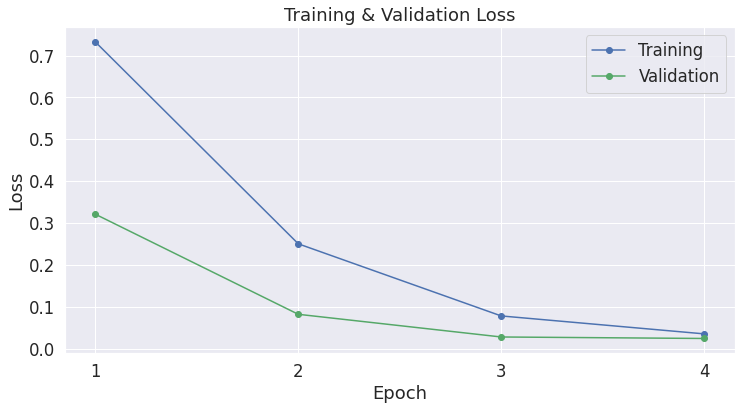

In [39]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Let's view the summary of the training process.


## Display Model Info

In [41]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50258, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

## predict

In [42]:
# record from data that has not seen
data[5640]

'K3809285 25/12/2014 Αταλάντη Atalante Κατσιλλή Katsille Απόλλων Ναυσικά Μπούζα 29/10/1955 Μεσσηνία Έδεσσα Πολύγυρος 57293/6 Υ.Α. Έδεσσα Μεσσηνία, Δημότης: Πολύγυρος 57293/6<|endoftext|>'

In [45]:
model.eval()

prompt = "B0907602 18/10/2016 Σεραφείμ Isabella Παπαχαραλάμπου Zoe Βασίλης Φιλίππα Σακελλαρίου 09/05/1926 Ροδόπη Λάρισα Καρπενήσι 92821/7 Υ.Α. Λάρισα Ροδόπη,"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 200,
                                top_p=0.95, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: B0907602 18/10/2016 Σεραφείμ Isabella Παπαχαραλάμπου Zoe Βασίλης Φιλίππα Σακελλαρίου 09/05/1926 Ροδόπη Λάρισα Καρπενήσι 92821/7 Υ.Α. Λάρισα Ροδόπη, Πατρώνυμο: Βασίλης


1: B0907602 18/10/2016 Σεραφείμ Isabella Παπαχαραλάμπου Zoe Βασίλης Φιλίππα Σακελλαρίου 09/05/1926 Ροδόπη Λάρισα Καρπενήσι 92821/7 Υ.Α. Λάρισα Ροδόπη, Αρχή Έκδοσης Δελτίου: Υ.Α. Λάρισα Ροδόπη


2: B0907602 18/10/2016 Σεραφείμ Isabella Παπαχαραλάμπου Zoe Βασίλης Φιλίππα Σακελλαρίου 09/05/1926 Ροδόπη Λάρισα Καρπενήσι 92821/7 Υ.Α. Λάρισα Ροδόπη, Mητέρας Όνομα: Φιλίππα


3: B0907602 18/10/2016 Σεραφείμ Isabella Παπαχαραλάμπου Zoe Βασίλης Φιλίππα Σακελλαρίου 09/05/1926 Ροδόπη Λάρισα Καρπενήσι 92821/7 Υ.Α. Λάρισα Ροδόπη, Καταγωγή: Ροδόπη Λάρισα


4: B0907602 18/10/2016 Σεραφείμ Isabella Παπαχαραλάμπου Zoe Βασίλης Φιλίππα Σακελλαρίου 09/05/1926 Ροδόπη Λάρισα Καρπενήσι 92821/7 Υ.Α. Λάρισα Ροδόπη, Given Name: Isabella




# Save model to google drive

In [46]:
import os
from google.colab import drive

In [47]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [48]:
!ls -l --block-size=K ./model_save/

total 499792K
-rw-r--r-- 1 root root      1K Jul 27 10:45 added_tokens.json
-rw-r--r-- 1 root root      1K Jul 27 10:45 config.json
-rw-r--r-- 1 root root    446K Jul 27 10:45 merges.txt
-rw-r--r-- 1 root root 498445K Jul 27 10:45 pytorch_model.bin
-rw-r--r-- 1 root root      1K Jul 27 10:45 special_tokens_map.json
-rw-r--r-- 1 root root      1K Jul 27 10:45 tokenizer_config.json
-rw-r--r-- 1 root root    878K Jul 27 10:45 vocab.json


In [49]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Jul 27 10:45 ./model_save/pytorch_model.bin


## Path to your google Drive 

In [50]:
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, '"My Drive"','"Colab Notebooks"', "GPT2QA", "v7")

drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/gdrive/


## Copy to Gdrive

In [51]:
!cp -r ./model_save/ $data_dir

## Everything set up